In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt

In [2]:
def get_step(steps, num_bars):
    assert steps > 1, "Steps have to be > 1"
    import sys
    import time
    import datetime
    idx = 0
    start = time.time()
    def step(info):
        nonlocal steps
        nonlocal num_bars
        nonlocal idx
        nonlocal start
        
        progress = int((idx/(steps-1))*100)
        bars = int((idx/(steps-1))*num_bars)
        elapsed = time.time() - start
        avg_iter = elapsed/(idx+1)
        remaining = (steps - idx)
        eta = int(avg_iter * remaining)
        sys.stdout.write('\r')
        # the exact output you're looking for:
        sys.stdout.write("[{bars:{num_bars}}] {progress:3}% [ETA:{seconds}] {info}".format(bars = '='*(bars-1)+'>', 
                                                                  progress = progress,
                                                                  num_bars = num_bars,
                                                                  seconds = datetime.timedelta(seconds = eta),
                                                                  info = info))
        sys.stdout.flush()
        idx += 1
    
    return step

In [3]:
# import time
# steps = 100
# step = get_step(steps,40)
# for i in range(steps):
#     step('Test')
#     time.sleep(0.1)

In [4]:
class Encoder(nn.Module): # pylint: disable=too-many-instance-attributes
    """ VAE encoder """
    def __init__(self, img_channels, latent_size):
        super(Encoder, self).__init__()
        self.latent_size = latent_size
        self.img_channels = img_channels

        self.conv1 = nn.Conv2d(img_channels, 32, 3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3,stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3,stride=2)
        
        self.fc_mu = nn.Linear(2*2*64, latent_size)
        self.fc_logsigma = nn.Linear(2*2*64, latent_size)


    def forward(self, x): # pylint: disable=arguments-differ
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)

        return mu, logsigma

class Decoder(nn.Module):
    """ VAE decoder """
    def __init__(self, img_channels, latent_size):
        super(Decoder, self).__init__()
        self.latent_size = latent_size
        self.img_channels = img_channels

        self.fc1 = nn.Linear(latent_size, 256)
        self.fc2 = nn.Linear(256, 784)
        self.deconv = nn.ConvTranspose2d(32, img_channels, 3, stride=2)

    def forward(self, x): # pylint: disable=arguments-differ
        x = F.relu(self.fc1(x))
        # x = x.unsqueeze(-1).unsqueeze(-1)
        reconstruction = F.sigmoid(self.fc2(x))
        return reconstruction.view(-1,1,28,28)



class VAE(nn.Module):
    """ Variational Autoencoder """
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x): # pylint: disable=arguments-differ
        mu, logsigma = self.encoder(x)
        
        sigma = logsigma.exp()
        eps = torch.randn_like(sigma)
        z = eps.mul(sigma).add_(mu)
        #z = torch.normal(mu,sigma) 

        recon_x = self.decoder(z)
        
        return recon_x, mu, logsigma


In [5]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logsigma):
    """ VAE loss function """
    #BCE = F.mse_loss(recon_x, x, size_average=False)
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp()) * 4
    return BCE + KLD

def train(epoch,epochs):
    """ One training epoch """
    model.train()
    train_loss = 0
    iterations = len(dataloader)
    step = get_step(steps=iterations,num_bars=40)
    for batch_idx, (data, _) in enumerate(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        step('Loss: {:.6f}'.format(loss.item() / len(data)))

    print('\nEpoch: {}/{} Average loss: {:.4f}'.format(
        epoch+1,epochs,train_loss / len(dataloader.dataset)))


def test():
    """ One test epoch """
    model.eval()
    dataset_test.load_next_buffer()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

def get_one(generator):
    return iter(generator).next()

In [6]:
input_dim = 28 * 28
batch_size = 128
img_channels = 1
latent_size = 10
learning_rate = 1e-3

transform = transforms.Compose(
    [transforms.ToTensor()])
mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(mnist, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

print('Number of samples: ', len(mnist))

Number of samples:  60000


In [7]:
encoder = Encoder(img_channels, latent_size)
decoder = Decoder(img_channels, latent_size)
model = VAE(encoder,decoder)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
iterations = 4
for iteration in range(iterations):
    train(iteration,iterations)

[=======================================>] 100% [ETA:0:00:00] Loss: 177.447713
Epoch: 1/4 Average loss: 207.1918
[=======================================>] 100% [ETA:0:00:00] Loss: 166.151988
Epoch: 2/4 Average loss: 166.9801
[=======================================>] 100% [ETA:0:00:00] Loss: 156.525675
Epoch: 3/4 Average loss: 159.8736
[=======================================>] 100% [ETA:0:00:00] Loss: 151.543254
Epoch: 4/4 Average loss: 157.1898


In [9]:
im = get_one(dataloader)
print(im[0].shape)
print(im[1].shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


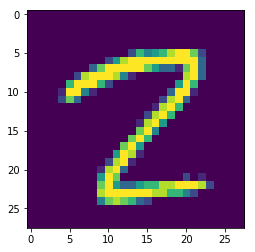

In [10]:
test = im[0][0][0] #+ torch.Tensor(np.random.normal(0,0.3,[28,28]))
plt.imshow(test)

torch.Size([1, 1, 28, 28])


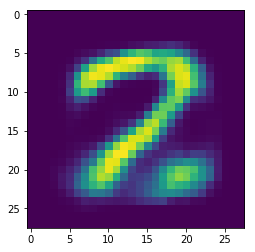

In [11]:
recon_x, mu, logsigma = model(test.unsqueeze(0).unsqueeze(0))
print(recon_x.shape)
plt.imshow(recon_x[0][0].detach())

In [35]:
# Display a 2D manifold of the digits
n = 40  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
x = np.linspace(0.05, 0.95, n)
y = np.linspace(0.05, 0.95, n)
grid_x, grid_y = np.meshgrid(x,y)

t_x = torch.Tensor(grid_x).view(-1,1)
t_y = torch.Tensor(grid_y).view(-1,1)
t = torch.cat((t_x,t_y),dim=1)
samples = decoder(t).detach().numpy().reshape(n,n,digit_size,digit_size)

# decode for each square in the grid
for i in range(n):
    for j in range(n):
        digit = samples[i][j]
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='gray')
plt.show()

RuntimeError: size mismatch, m1: [1600 x 2], m2: [10 x 256] at /Users/soumith/minicondabuild3/conda-bld/pytorch_1524590658547/work/aten/src/TH/generic/THTensorMath.c:2033

In [119]:
t_x = torch.Tensor(grid_x).view(-1,1)
t_y = torch.Tensor(grid_y).view(-1,1)
t = torch.cat((t_x,t_y),dim=1)

In [134]:
r = decoder(t).detach().numpy().reshape(n,n,digit_size,digit_size)

In [52]:
mu, logsigma = encoder(im[0])
sigma = logsigma.exp()
eps = torch.randn_like(sigma)
z = eps.mul(sigma).add_(mu)

In [53]:
z.shape

torch.Size([32, 2])

In [24]:
res = decoder(z[0].unsqu)

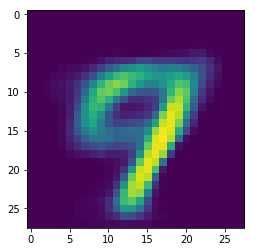

In [34]:
plt.imshow(res[5][0].detach())

In [38]:
z[5].unsqueeze(0).shape

torch.Size([1, 2])

In [ ]:


criterion = nn.MSELoss()

optimizer = optim.Adam(vae.parameters(), lr=0.0001)
l = None
for epoch in range(100):
    for i, data in enumerate(dataloader, 0):
        inputs, classes = data
        inputs, classes = Variable(inputs.resize_(batch_size, input_dim)), Variable(classes)
        optimizer.zero_grad()
        dec = vae(inputs)
        ll = latent_loss(vae.z_mean, vae.z_sigma)
        loss = criterion(dec, inputs) + ll
        loss.backward()
        optimizer.step()
        l = loss.data[0]
    print(epoch, l)

plt.imshow(vae(inputs).data[0].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)


In [18]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image



batch_size = 128
epochs=10
seed=1
cuda = torch.cuda.is_available()
log_interval = 10

torch.manual_seed(seed)

device = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.572632
Train Epoch: 1 [1280/60000 (2%)]	Loss: 309.673523
Train Epoch: 1 [2560/60000 (4%)]	Loss: 236.217880
Train Epoch: 1 [3840/60000 (6%)]	Loss: 225.817917
Train Epoch: 1 [5120/60000 (9%)]	Loss: 209.388962
Train Epoch: 1 [6400/60000 (11%)]	Loss: 206.767288
Train Epoch: 1 [7680/60000 (13%)]	Loss: 209.222809
Train Epoch: 1 [8960/60000 (15%)]	Loss: 200.530899
Train Epoch: 1 [10240/60000 (17%)]	Loss: 190.547012
Train Epoch: 1 [11520/60000 (19%)]	Loss: 190.907318
Train Epoch: 1 [12800/60000 (21%)]	Loss: 187.600830
Train Epoch: 1 [14080/60000 (23%)]	Loss: 172.074402
Train Epoch: 1 [15360/60000 (26%)]	Loss: 177.232468
Train Epoch: 1 [16640/60000 (28%)]	Loss: 171.121414
Train Epoch: 1 [17920/60000 (30%)]	Loss: 168.403152
Train Epoch: 1 [19200/60000 (32%)]	Loss: 162.337891
Train Epoch: 1 [20480/60000 (34%)]	Loss: 158.159317
Train Epoch: 1 [21760/60000 (36%)]	Loss: 158.383118
Train Epoch: 1 [23040/60000 (38%)]	Loss: 155.736801
Train Epoch: 1 [24320/60000 

Train Epoch: 4 [17920/60000 (30%)]	Loss: 113.810966
Train Epoch: 4 [19200/60000 (32%)]	Loss: 110.596909
Train Epoch: 4 [20480/60000 (34%)]	Loss: 112.290855
Train Epoch: 4 [21760/60000 (36%)]	Loss: 114.098045
Train Epoch: 4 [23040/60000 (38%)]	Loss: 112.974152
Train Epoch: 4 [24320/60000 (41%)]	Loss: 113.832870
Train Epoch: 4 [25600/60000 (43%)]	Loss: 110.029922
Train Epoch: 4 [26880/60000 (45%)]	Loss: 112.108093
Train Epoch: 4 [28160/60000 (47%)]	Loss: 111.910477
Train Epoch: 4 [29440/60000 (49%)]	Loss: 109.208374
Train Epoch: 4 [30720/60000 (51%)]	Loss: 106.530945
Train Epoch: 4 [32000/60000 (53%)]	Loss: 110.315308
Train Epoch: 4 [33280/60000 (55%)]	Loss: 110.747658
Train Epoch: 4 [34560/60000 (58%)]	Loss: 104.247772
Train Epoch: 4 [35840/60000 (60%)]	Loss: 109.955154
Train Epoch: 4 [37120/60000 (62%)]	Loss: 112.263504
Train Epoch: 4 [38400/60000 (64%)]	Loss: 109.734283
Train Epoch: 4 [39680/60000 (66%)]	Loss: 112.842484
Train Epoch: 4 [40960/60000 (68%)]	Loss: 108.529259
Train Epoch:

Train Epoch: 7 [35840/60000 (60%)]	Loss: 108.715820
Train Epoch: 7 [37120/60000 (62%)]	Loss: 109.702118
Train Epoch: 7 [38400/60000 (64%)]	Loss: 107.469727
Train Epoch: 7 [39680/60000 (66%)]	Loss: 107.641518
Train Epoch: 7 [40960/60000 (68%)]	Loss: 104.378700
Train Epoch: 7 [42240/60000 (70%)]	Loss: 104.906540
Train Epoch: 7 [43520/60000 (72%)]	Loss: 107.486771
Train Epoch: 7 [44800/60000 (75%)]	Loss: 108.889473
Train Epoch: 7 [46080/60000 (77%)]	Loss: 104.638390
Train Epoch: 7 [47360/60000 (79%)]	Loss: 107.324936
Train Epoch: 7 [48640/60000 (81%)]	Loss: 105.836311
Train Epoch: 7 [49920/60000 (83%)]	Loss: 106.953873
Train Epoch: 7 [51200/60000 (85%)]	Loss: 109.550835
Train Epoch: 7 [52480/60000 (87%)]	Loss: 107.109138
Train Epoch: 7 [53760/60000 (90%)]	Loss: 108.635193
Train Epoch: 7 [55040/60000 (92%)]	Loss: 106.635330
Train Epoch: 7 [56320/60000 (94%)]	Loss: 108.545006
Train Epoch: 7 [57600/60000 (96%)]	Loss: 103.551331
Train Epoch: 7 [58880/60000 (98%)]	Loss: 104.508865
====> Epoch:

Train Epoch: 10 [52480/60000 (87%)]	Loss: 104.774734
Train Epoch: 10 [53760/60000 (90%)]	Loss: 107.218857
Train Epoch: 10 [55040/60000 (92%)]	Loss: 100.997055
Train Epoch: 10 [56320/60000 (94%)]	Loss: 109.691734
Train Epoch: 10 [57600/60000 (96%)]	Loss: 106.882431
Train Epoch: 10 [58880/60000 (98%)]	Loss: 105.880547
====> Epoch: 10 Average loss: 105.8832
====> Test set loss: 97.0524
